# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold


In [4]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [6]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [7]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

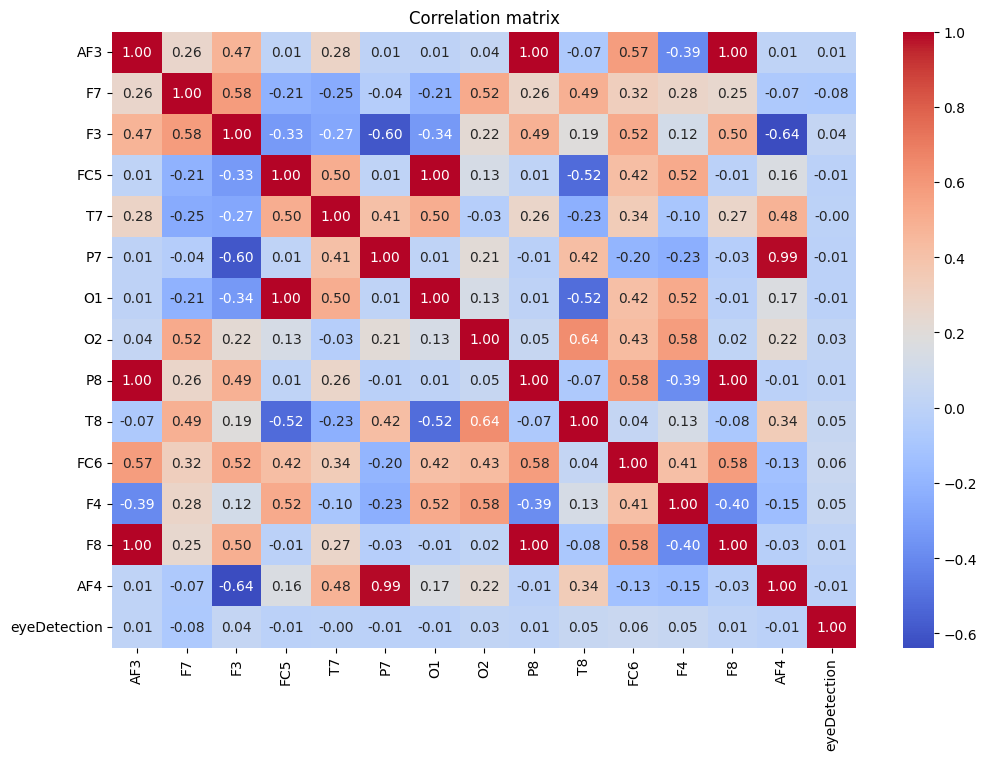

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [9]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [10]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [11]:
df.duplicated().any()

np.False_

In [12]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

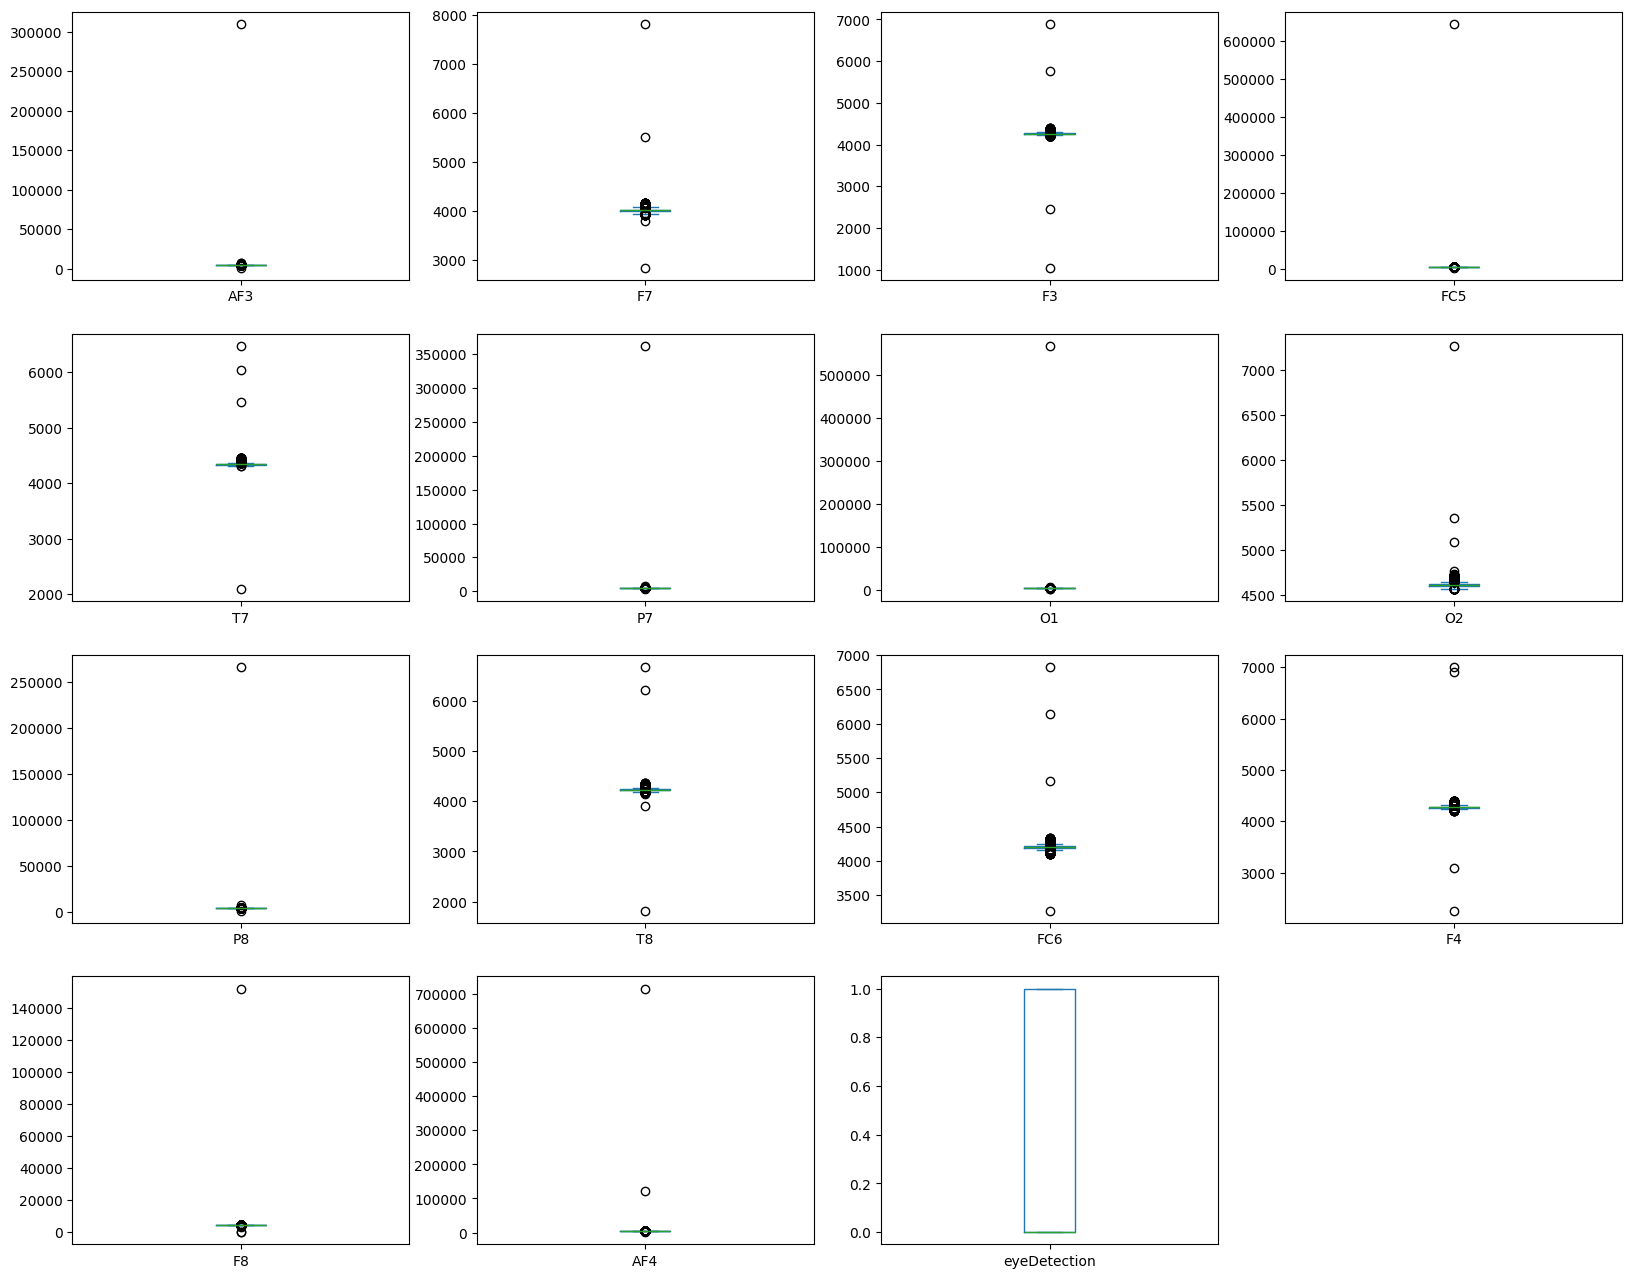

In [13]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

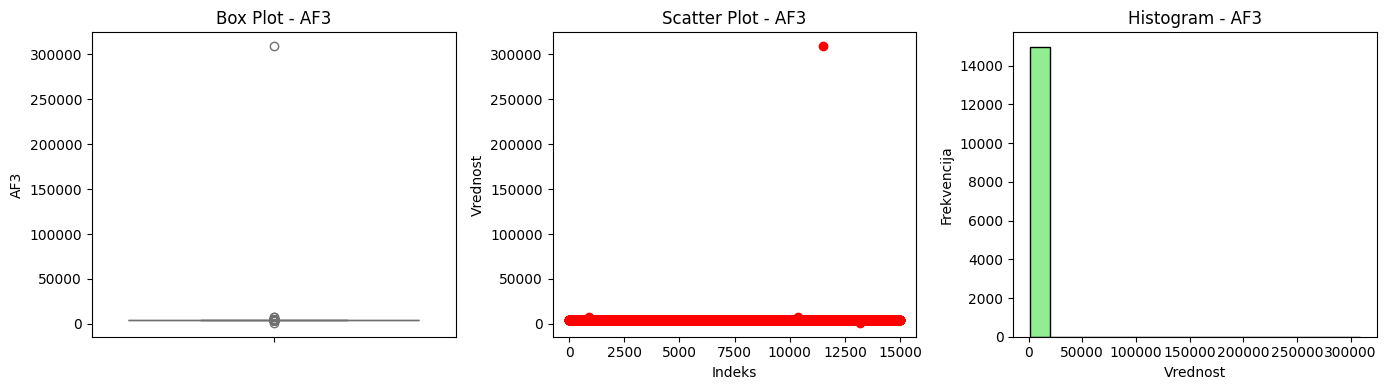

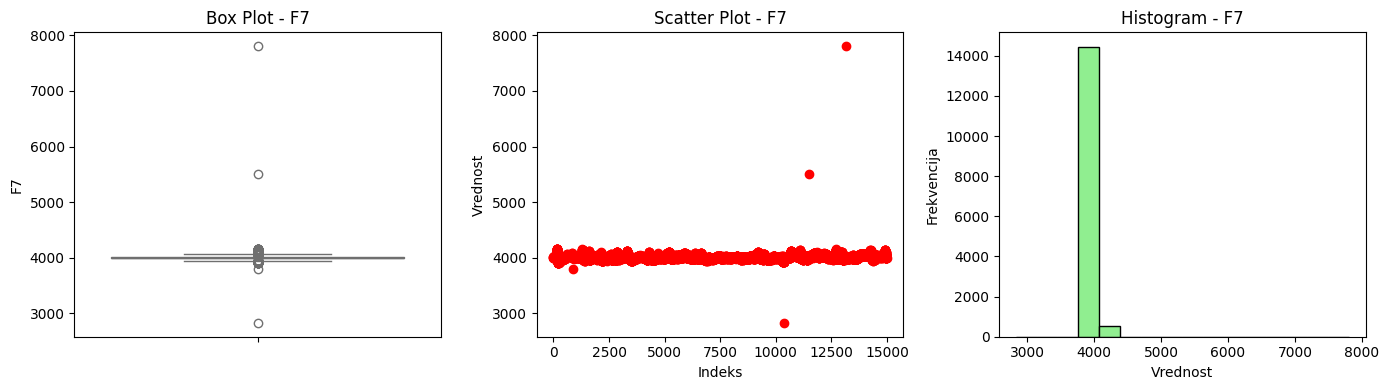

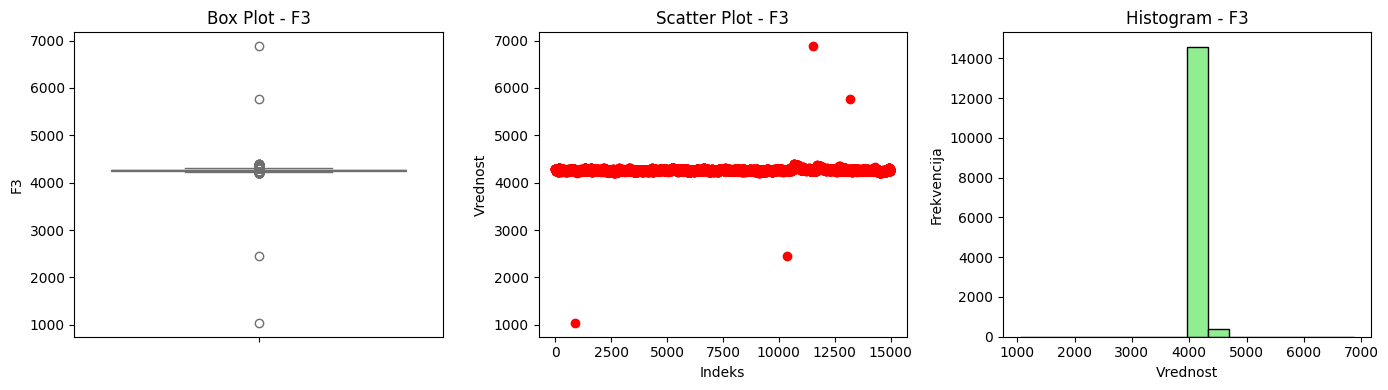

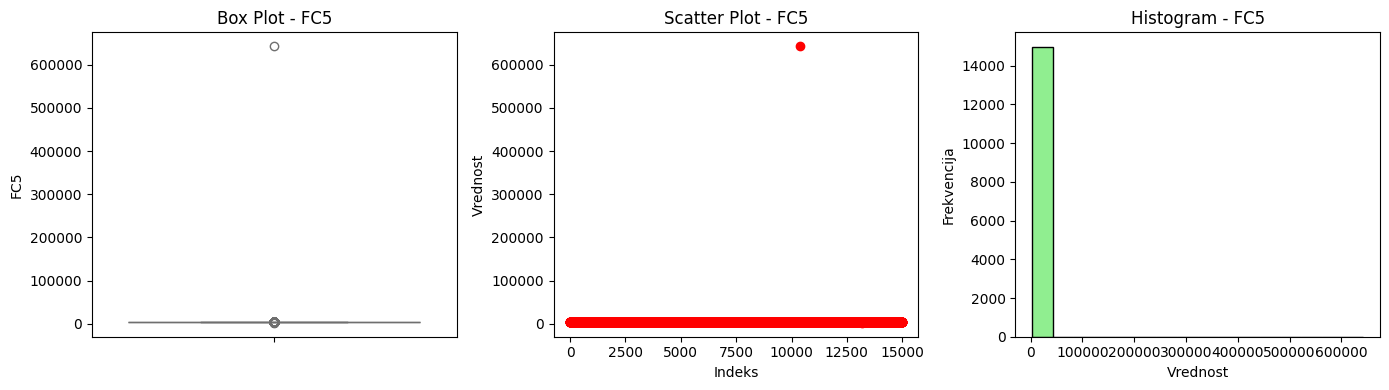

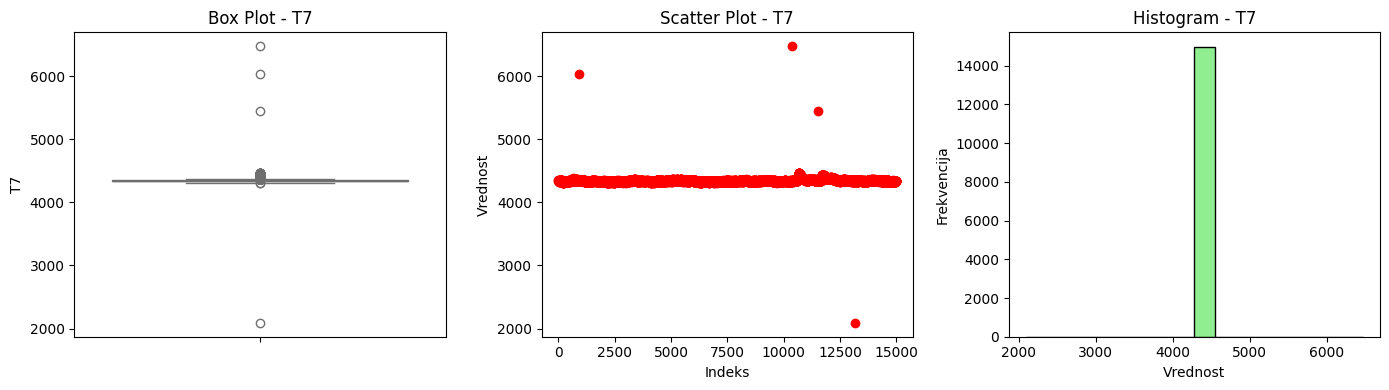

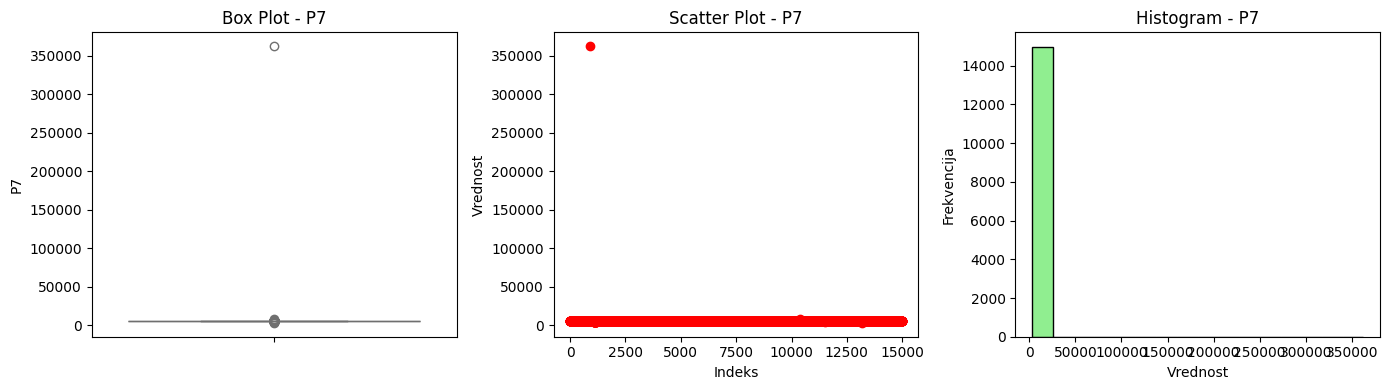

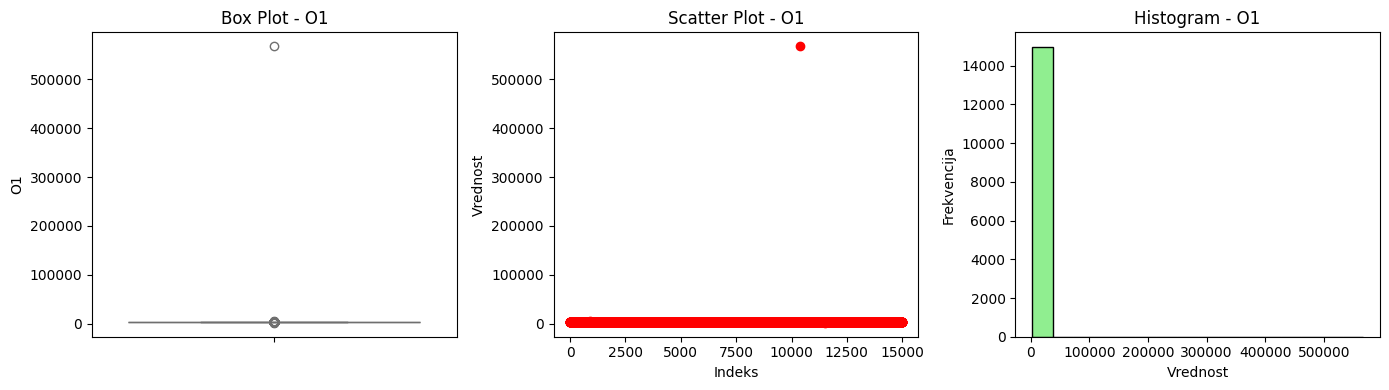

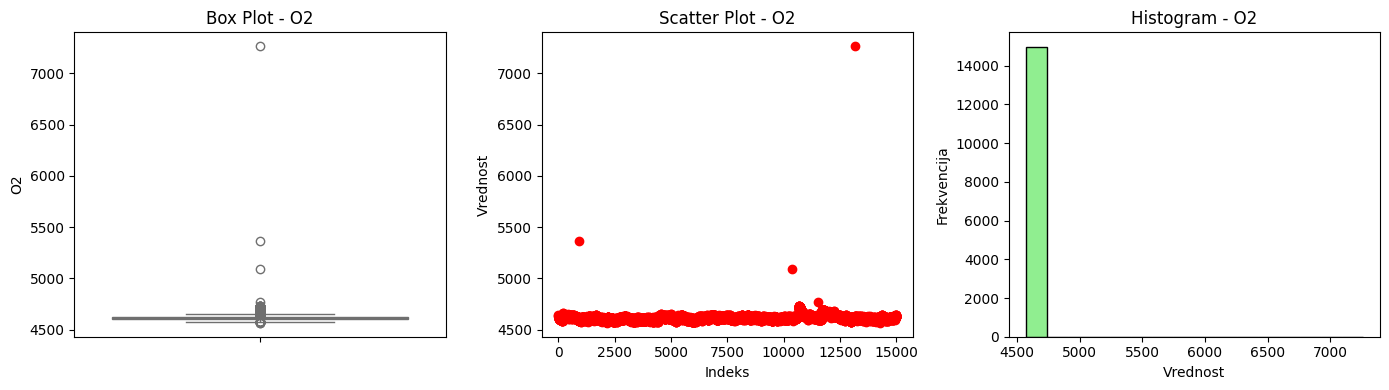

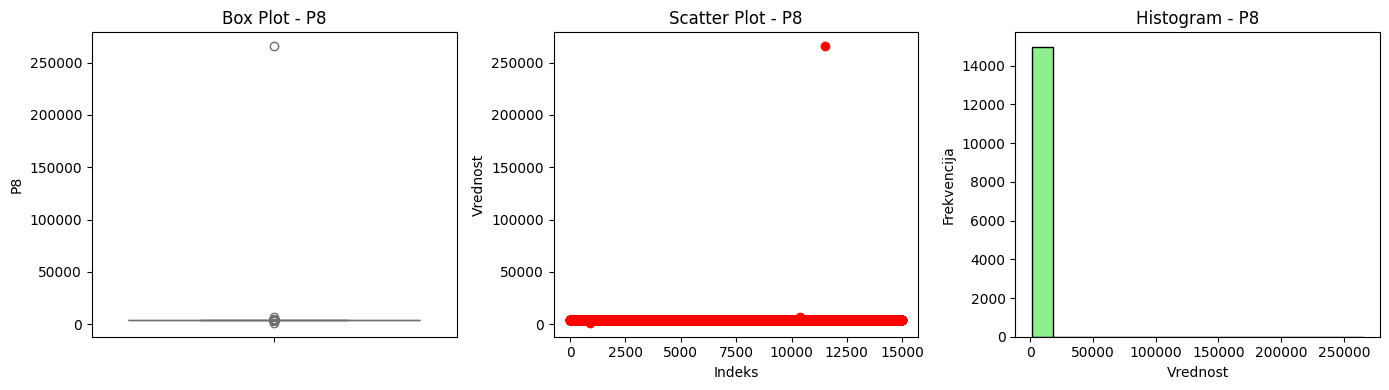

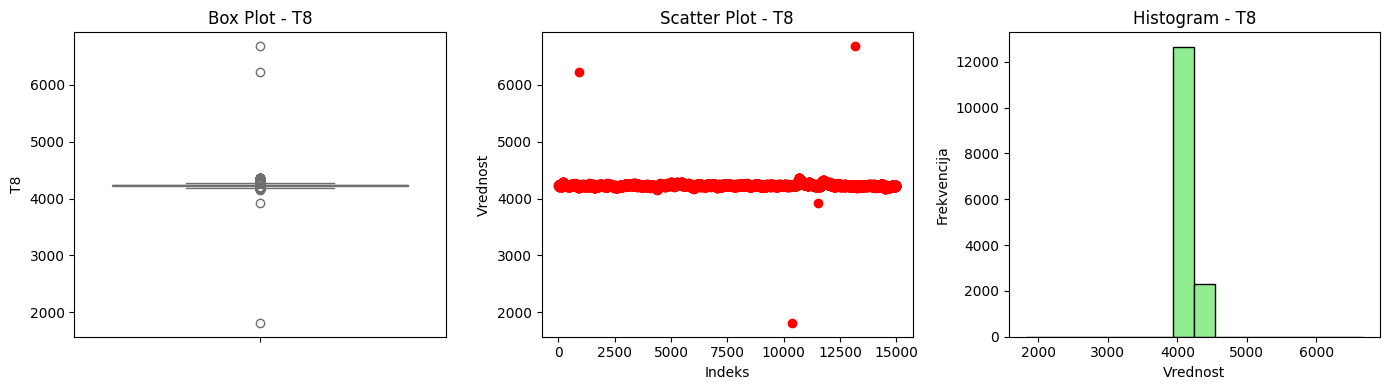

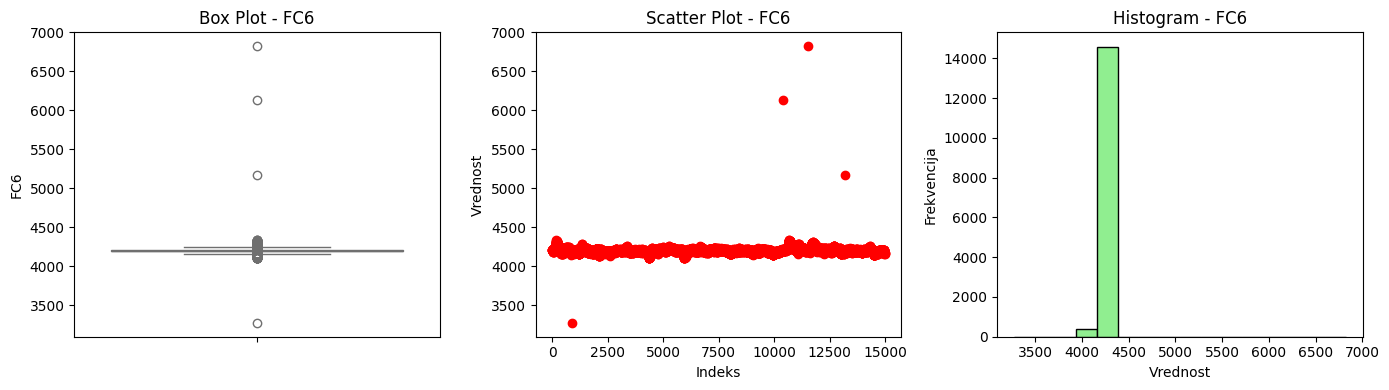

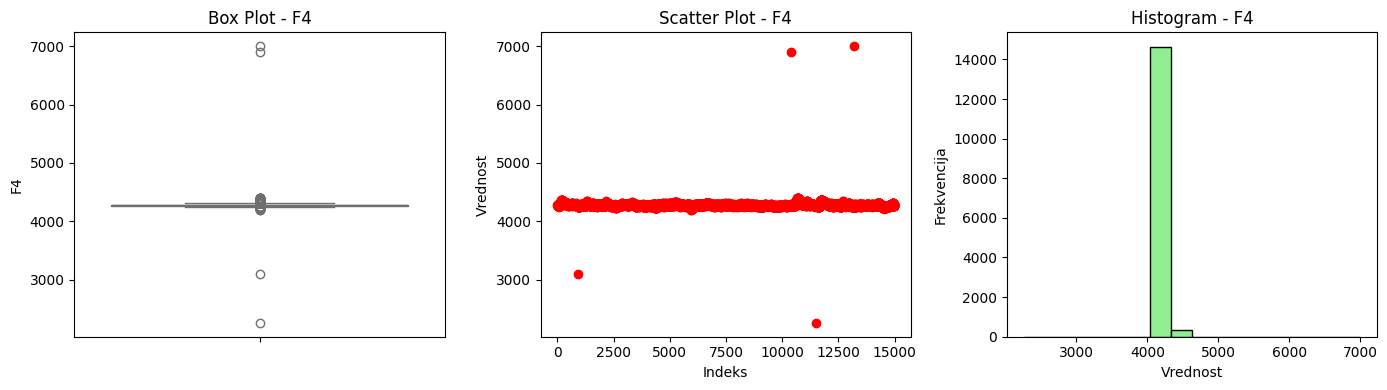

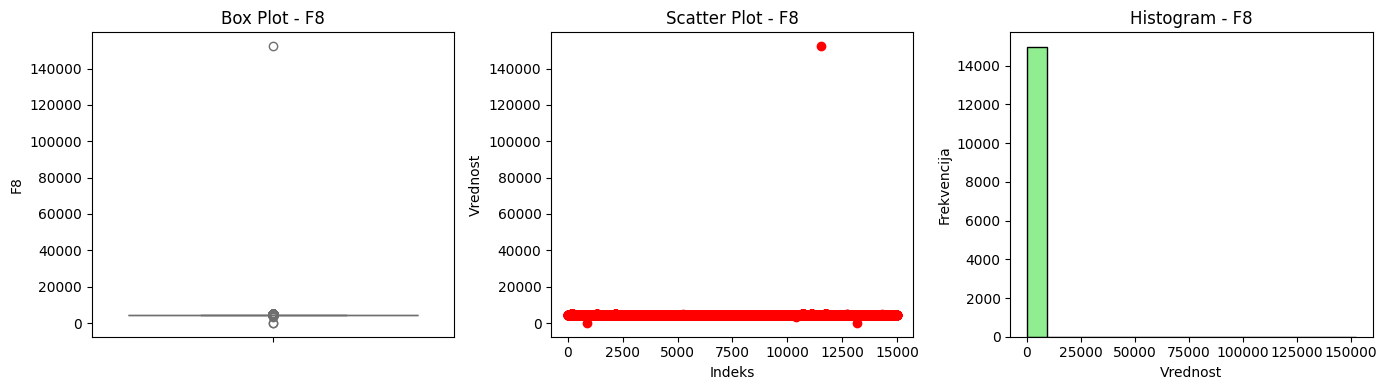

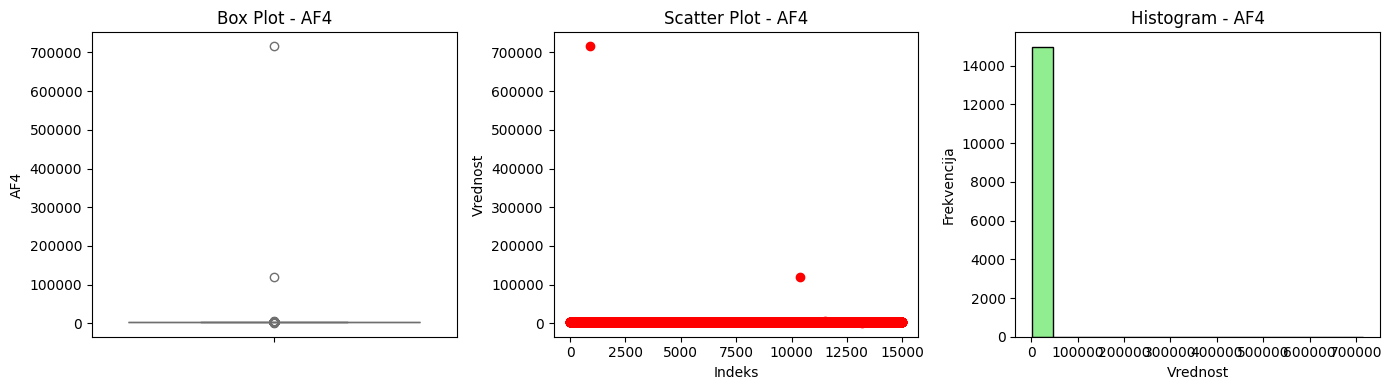

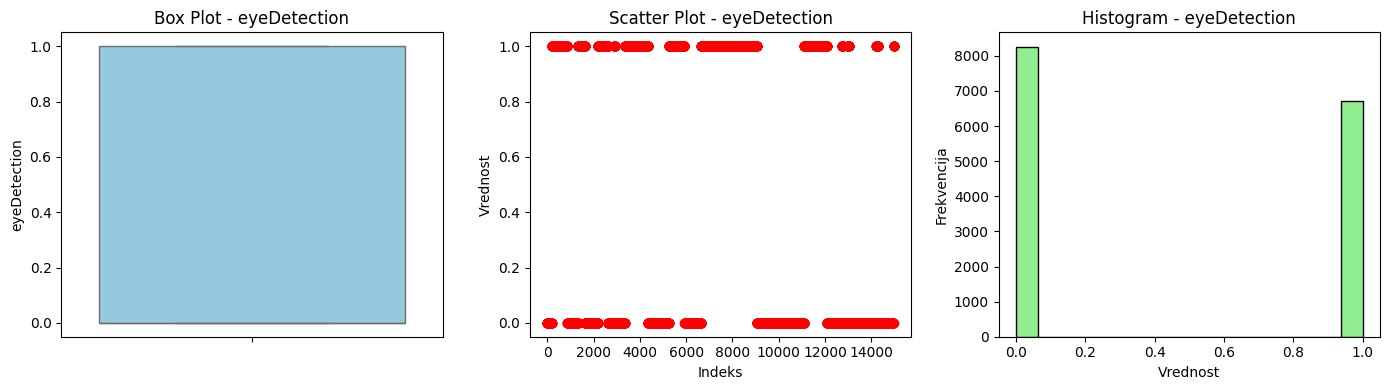

In [14]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [15]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [16]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 3. Transformacija podataka

Pretvaranje tekstualnih vrednosti u numeričke: One-Hot Encoding metoda

In [17]:
df_encoded = pd.get_dummies(df, columns=['eyeDetection'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AF3             14980 non-null  float64
 1   F7              14980 non-null  float64
 2   F3              14980 non-null  float64
 3   FC5             14980 non-null  float64
 4   T7              14980 non-null  float64
 5   P7              14980 non-null  float64
 6   O1              14980 non-null  float64
 7   O2              14980 non-null  float64
 8   P8              14980 non-null  float64
 9   T8              14980 non-null  float64
 10  FC6             14980 non-null  float64
 11  F4              14980 non-null  float64
 12  F8              14980 non-null  float64
 13  AF4             14980 non-null  float64
 14  eyeDetection_0  14980 non-null  bool   
 15  eyeDetection_1  14980 non-null  bool   
dtypes: bool(2), float64(14)
memory usage: 1.6 MB


In [18]:
df_encoded.iloc[0:10, 14:16]

,eyeDetection_0,eyeDetection_1
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
5,True,False
6,True,False
7,True,False
8,True,False
9,True,False


## 4. Treniranje modela

### Podela podataka:

In [19]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11984, 14)
(2996, 14)
(11984,)
(2996,)


### Lazy Predict

In [20]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None, 
    predictions=False,
)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Funkcija za izveštaj o performansama modela:

In [76]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def report(y_test, y_pred, title):
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "accuracy": acc,
        "classification_report": cr,  # dict forma
        "confusion_matrix": cm
    }
   

### Random Forest

In [75]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def run_random_forest_classifier(X_train, y_train, X_test, y_test, preprocessors):
    forest = RandomForestClassifier(random_state=0, n_jobs=1)
    pipe = make_pipeline(*preprocessors, forest)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = report(y_test, y_pred, "Random Forest Classifier")
    return res["accuracy"]

### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

def run_extra_trees_classifier(X_train, y_train, X_test, y_test, preprocessors):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    pipe = make_pipeline(*preprocessors, et_classifier)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Extra Trees Classifier")
    return res["accuracy"]

    # print("\nFeature Importances:")
    # features_and_scores = zip(X.columns, et_classifier.feature_importances_)
    # sorted_features = sorted(features_and_scores, key=lambda x: x[1], reverse=True)

    # for feature, importance in sorted_features:
    #     print(f"{feature}: {importance:.4f}")
        

### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [73]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(X_train, y_train, X_test, y_test, preprocessors):
    # pipe = Pipeline([
    #     ("preprocessor", *preprocessors),
    #     ("knn", KNeighborsClassifier())
    # ])
    pipe = make_pipeline(*preprocessors, KNeighborsClassifier())


    k_values = range(1, 300, 2) 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    best_k, best_score = None, -1
    for k in k_values:
        pipe.set_params(kneighborsclassifier__n_neighbors=k)
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    # print(f"Najbolji K: {best_k}, CV accuracy: {best_score:.4f}")

    pipe.set_params(kneighborsclassifier__n_neighbors=best_k)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "K-Nearest Neighbour Classifier")
    return res["accuracy"]


### SVM

In [72]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0))
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "SVM Classifier")
    return res["accuracy"]

### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def run_logistic_regression_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = LogisticRegression(
        max_iter=100,
        solver="lbfgs",    
        n_jobs = 1
    )

    pipe = make_pipeline(*preprocessors, clf)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Logistic Regression Classifier")
    return res["accuracy"]
    

### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

def run_naive_bayes_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, GaussianNB())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Naive Bayes Classifier")
    return res["accuracy"]

### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [68]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = DecisionTreeClassifier(random_state=0)

    pipe = make_pipeline(*preprocessors, clf)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Decision Tree Classifier")
    return res["accuracy"]
    

In [ ]:
# def run_classifiers(X_train, y_train, X_test, y_test, prepocessors):
#     run_random_forest_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_extra_trees_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_knn_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_svm_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_logistic_regression_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_naive_bayes_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_decision_tree_classifier(X_train, y_train, X_test, y_test, prepocessors)

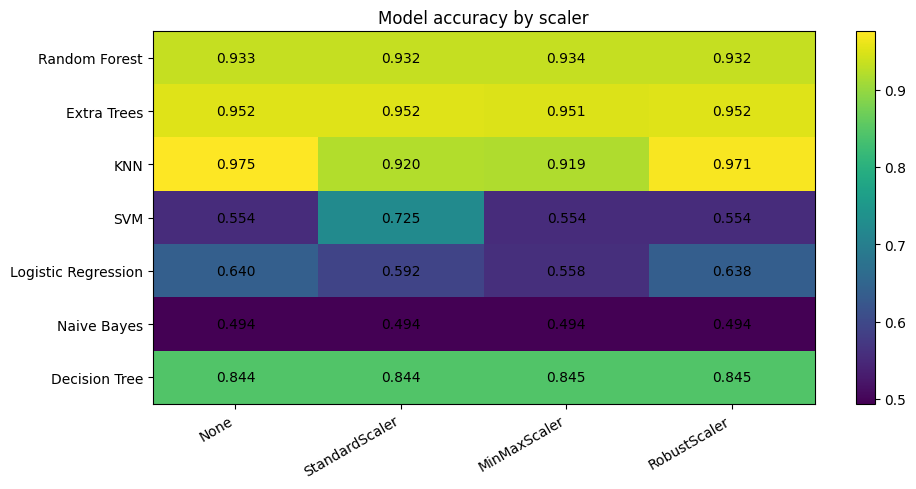

,None,StandardScaler,MinMaxScaler,RobustScaler
Random Forest,0.933,0.932,0.934,0.932
Extra Trees,0.952,0.952,0.951,0.952
KNN,0.975,0.920,0.919,0.971
SVM,0.554,0.725,0.554,0.554
Logistic Regression,0.640,0.592,0.558,0.638
Naive Bayes,0.494,0.494,0.494,0.494
Decision Tree,0.844,0.844,0.845,0.845


In [77]:

def _preprocessors_name(preprocessors):
    if not preprocessors:
        return "None"
    return " + ".join(type(p).__name__ for p in preprocessors)

def run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers_dict):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X_train, y_train, X_test, y_test, preprocessors)
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix = run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers)
plot_matrix_heatmap(acc_matrix, title="Model accuracy by scaler")

acc_matrix.style.background_gradient(axis=None).format("{:.3f}")



## 4. Optimizacija hiperparametra